In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week,\
forecast_by_week, train_test_split,update_deepAR_parameters, hyperparameter_boxplots,\
generate_model_results_by_hp_dict, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
import itertools
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()

In [2]:
df =  pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Hyperparameter_results_19_04.csv", sep=',')

hp_search_space = {
    "num_cells": tune.grid_search([10, 20, 40]),
    "num_layers": tune.grid_search([3, 4, 5]),
    "context_length":tune.grid_search([4, 52, 104]),
    "cell_type":tune.grid_search(["lstm", "gru"]),
    "epochs":tune.grid_search([8, 20, 30]),
    #"use_feat_static_real":tune.grid_search([False]),
    #"use_feat_dynamic_real":tune.grid_search([True]),
    "use_feat_static_cat":tune.grid_search([False,True]),
    "cardinality":tune.sample_from(lambda spec:[2]*411 if spec.config.use_feat_static_cat else None),
}

model_results_by_hp, overall_df = generate_model_results_by_hp_dict(df, hp_search_space)

                           total_modelruns  independent_combinations
modelruns_per_combination                                           
5.0                                   1620                     324.0


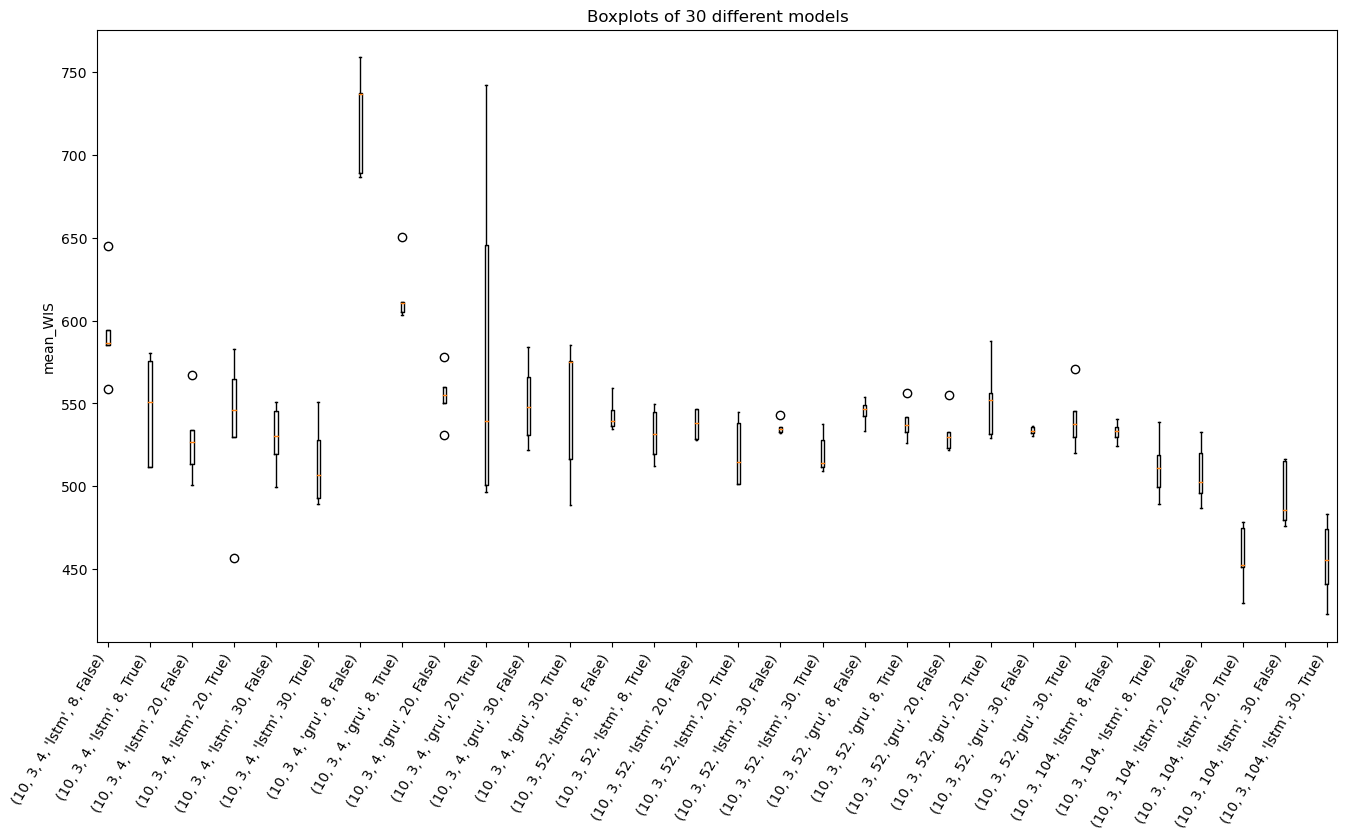

In [3]:
plot_model_results_by_hp(model_results_by_hp, number_of_plots=30, col="mean_WIS",figsize=(16, 9))

In [4]:
added_cols = ["model_WIS_mean","model_WIS_variance","model_WIS_sd","model_time_mean","model_time_variance","model_time_sd"]
display(overall_df.sort_values("model_time_mean")[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)&("use_feat_dynamic_real" not in col)&("use_feat_static_real" not in col)]].drop_duplicates().tail(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_time_mean,model_time_variance,model_time_sd,config/cell_type,config/context_length,config/epochs,config/num_cells,config/num_layers,config/use_feat_static_cat
485,472.174778,99.078983,9.953843,4599.647369,1.008844e+06,1004.412053,gru,104,30,40,5,False
214,490.257871,402.053817,20.051280,4601.441494,2.942630e+05,542.460163,lstm,104,30,40,3,True
250,502.206903,604.381094,24.584163,4609.412702,9.918900e+05,995.936721,lstm,104,30,20,4,True
310,530.212483,874.036179,29.564103,4663.225433,6.490961e+06,2547.736478,lstm,104,8,40,5,True
484,454.571901,1184.141927,34.411363,4726.528174,9.642118e+05,981.942887,lstm,104,30,40,5,False
320,582.719286,361.257159,19.006766,4753.812192,1.143310e+06,1069.256530,lstm,52,30,40,5,True
269,447.605081,3346.497453,57.848919,4859.470723,1.412727e+06,1188.581747,gru,104,30,40,4,True
641,490.129962,1022.480974,31.976256,4916.745821,1.304170e+06,1142.002470,gru,104,20,40,5,True
916,484.455072,1847.578282,42.983465,4958.903273,1.419748e+06,1191.531915,lstm,104,30,40,4,True
1612,510.326338,1897.351704,43.558601,5198.864171,1.797175e+06,1340.587728,lstm,104,20,40,5,True


324
1620


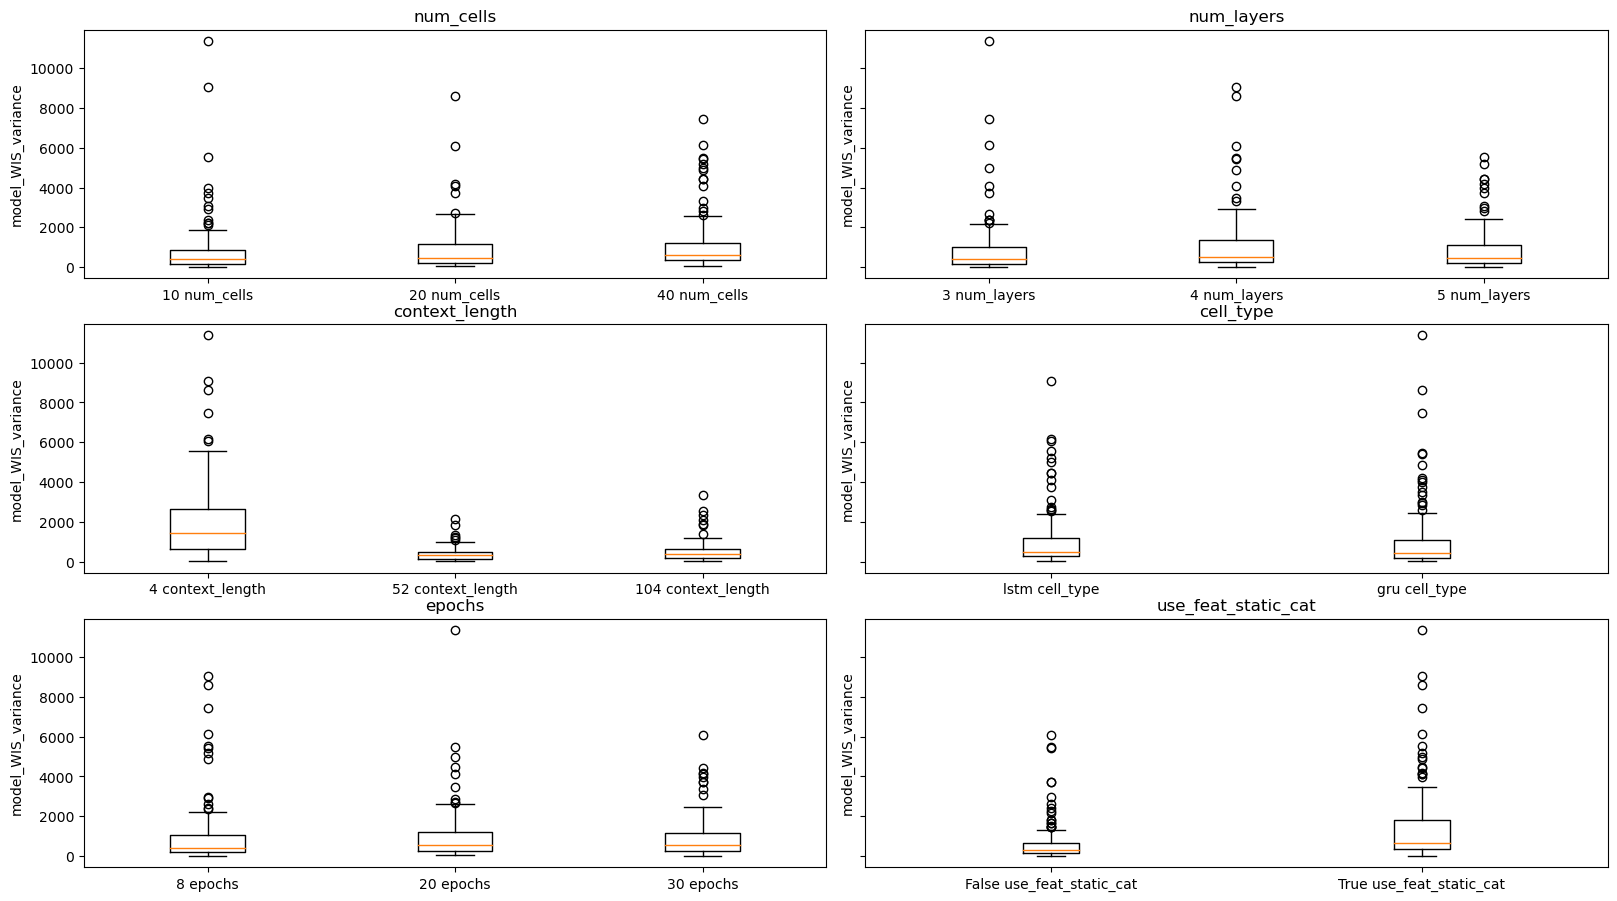

________________


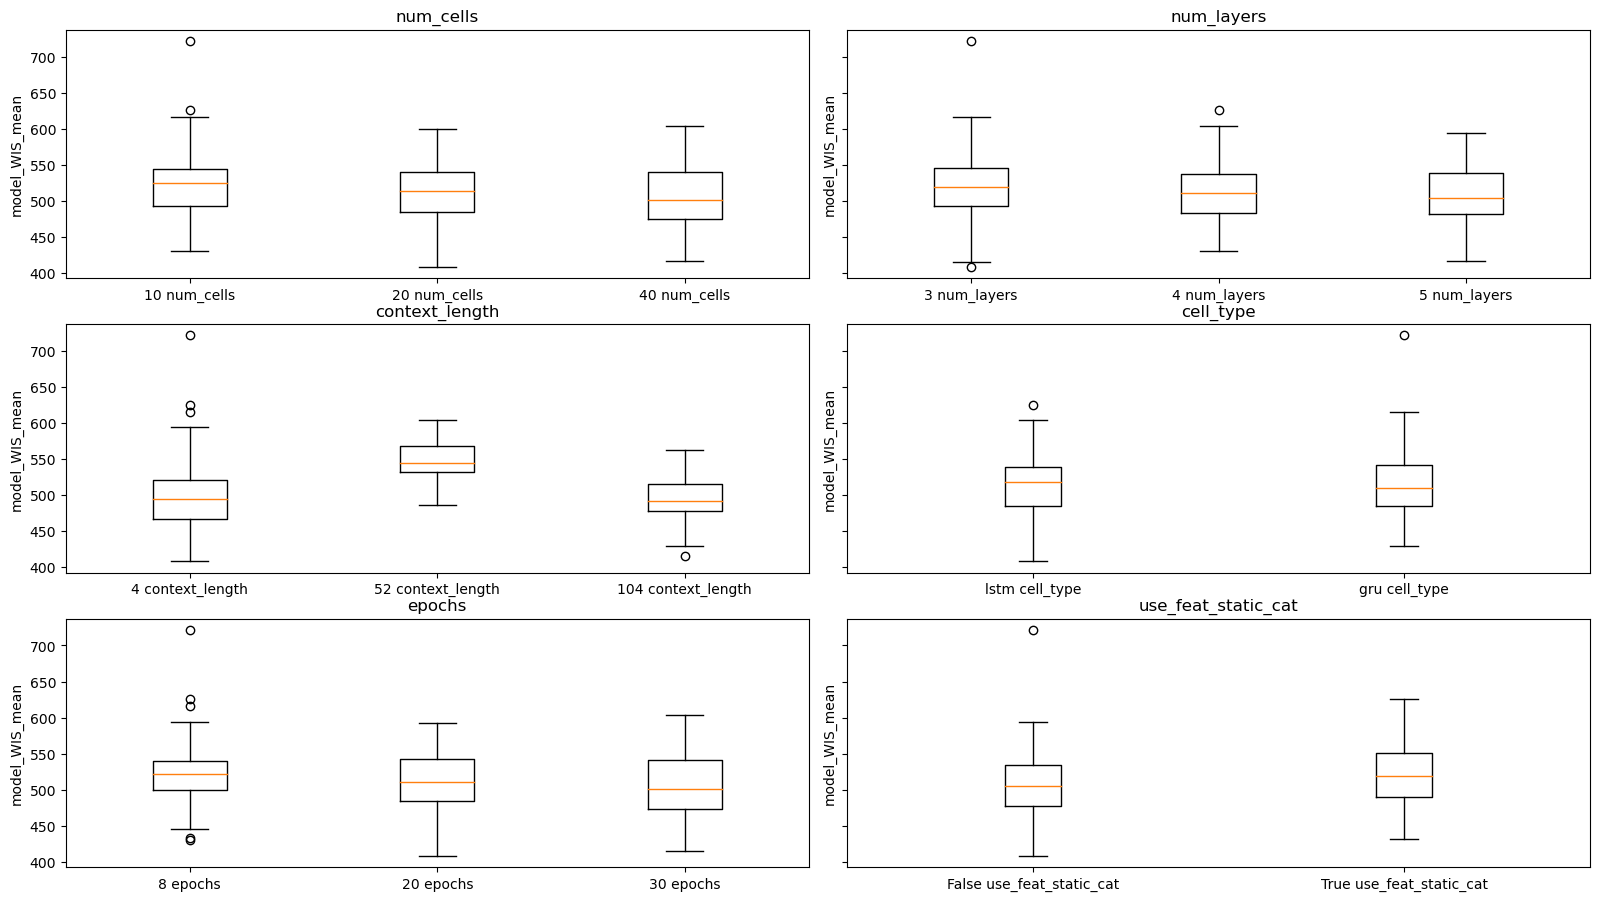

In [5]:
unique_df = overall_df[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
print(len(unique_df))
print(len(overall_df))
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_mean")

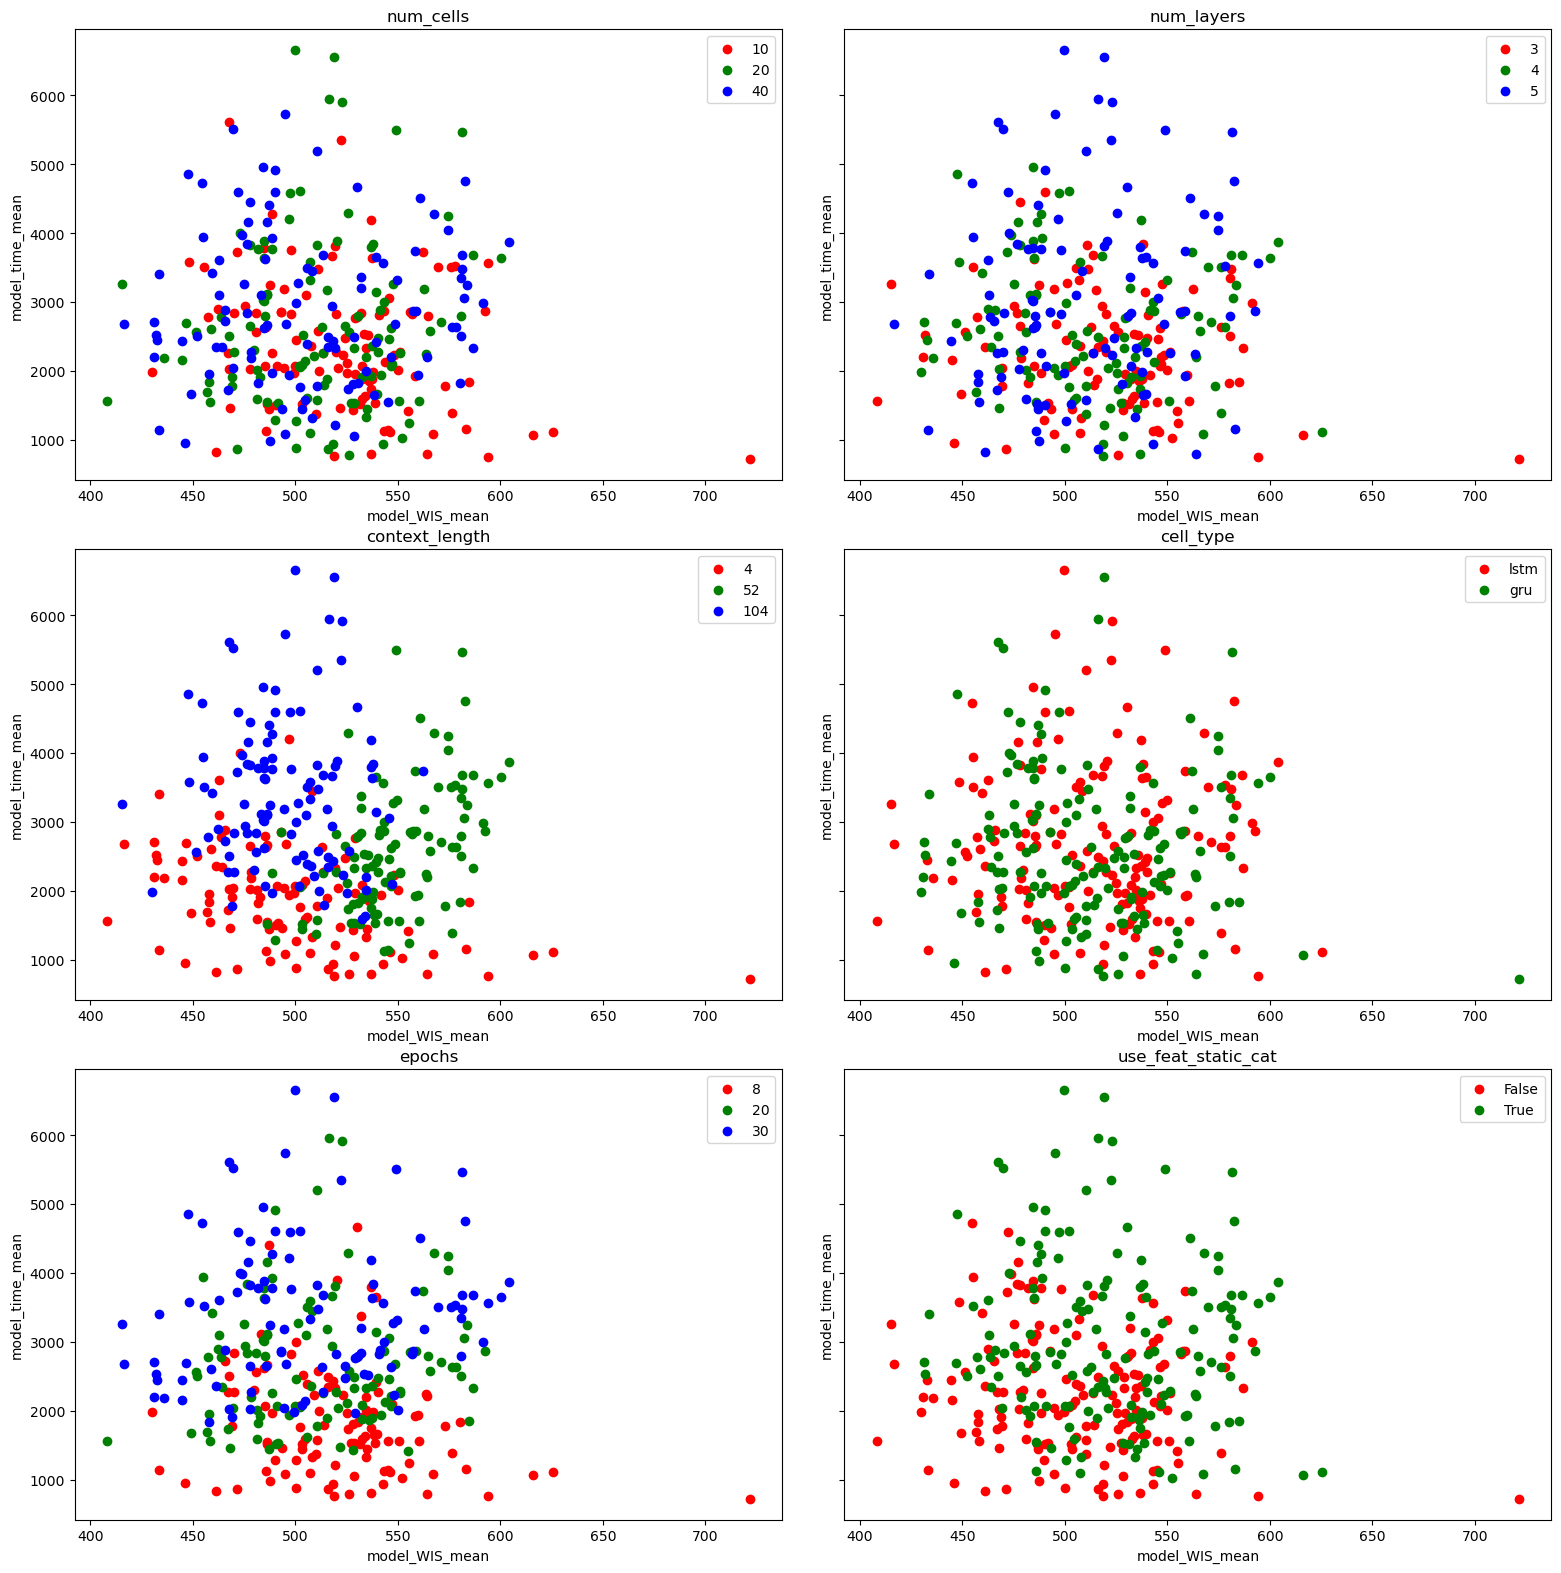

In [6]:
hp_color_plot(overall_df, hp_search_space)